# Introduction

**Problem Statement**<br>
* Cross-sell PredictionPredict Health Insurance Owners' who will be interested in Vehicle Insurance<br>
* 1 : Customer is interested, 0 : Customer is not interested

**Data**<br>
* Setiap baris mewakili data customer.<br>

**Link Kaggle**<br>
* https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction<br>

In [39]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

# Data Collection

## Load Data

In [2]:
data = pd.read_csv('input/train.csv')
data = data.drop('id', axis=1)
data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
data['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

# Data Understanding

## Data Description

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 32.0+ MB


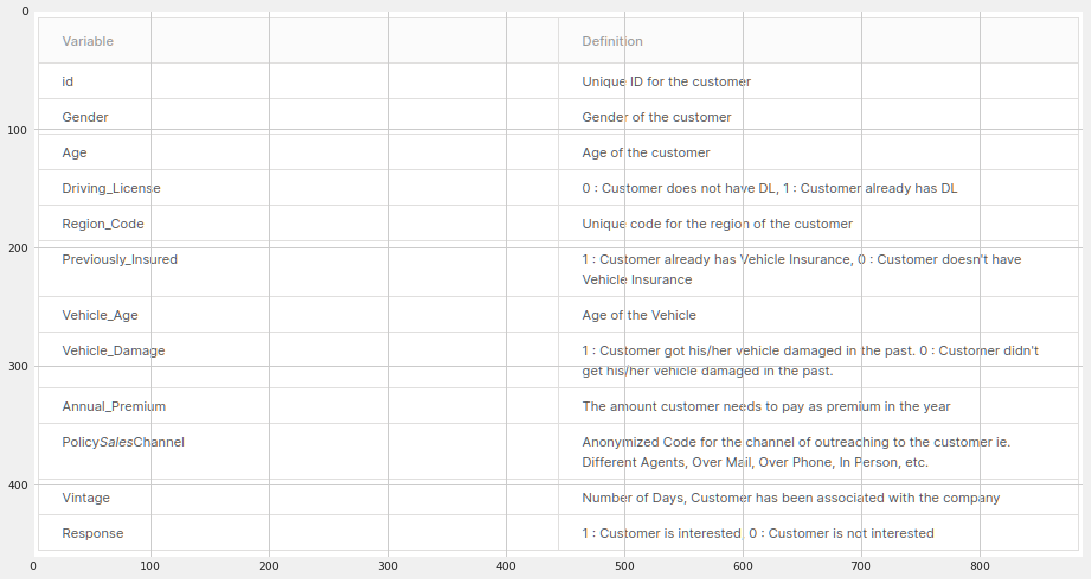

In [5]:
data_description = cv2.imread('fig/data_description.png')
plt.imshow(data_description)
plt.tight_layout()
plt.show()

## Numerical Data

In [6]:
numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
display(data.select_dtypes(include=numerics).columns)
print(data.select_dtypes(include=numerics).shape)
data_num = data.select_dtypes(include=numerics)
data_num.head(3)

Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

(381109, 8)


,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,44,1,28.0,0,40454.0,26.0,217,1
1,76,1,3.0,0,33536.0,26.0,183,0
2,47,1,28.0,0,38294.0,26.0,27,1


## Non Numerical Data

In [7]:
display(data.select_dtypes(include=['object']).columns)
print(data.select_dtypes(include=object).shape)
data_cat = data.select_dtypes(include=['object'])
data_cat.head(3)

Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')

(381109, 3)


,Gender,Vehicle_Age,Vehicle_Damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes


# Data Pre-Processing

## Missing Value

In [8]:
data_missing_value = data.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value['percentage'] = round((data_missing_value['missing_value']/len(data))*100,2)
data_missing_value = data_missing_value.sort_values('percentage', ascending=False).reset_index(drop=True)
data_missing_value = data_missing_value[data_missing_value['percentage']>0]
data_missing_value

,feature,missing_value,percentage


**Tidak ada missing value, artinya semua fitur memiliki nilai yang lengkap**

## Duplicate Values

In [9]:
data.duplicated().sum()

269

**remove duplicate values**

In [10]:
print('Total Row : ', len(data))
data = data.drop_duplicates()
print('Total Row after drop duplicates : ', len(data))

Total Row :  381109
Total Row after drop duplicates :  380840


In [11]:
# double check 
381109 - 269

380840

## Statistical Summary

In [12]:
data_num.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [13]:
data_cat.describe()

,Gender,Vehicle_Age,Vehicle_Damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


## Outlier

In [14]:
# features = ['Age','Region_Code','Annual_Premium','Policy_Sales_Channel','Vintage']
# data_num = data_num[features]
# k = len(data_num.columns)
# n = 3
# m = (k - 1) // n + 1
# fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3))
# for i, (name, col) in enumerate(data_num.iteritems()):
#     r, c = i // n, i % n
#     ax = axes[r, c]
#     col.hist(ax=ax, color='green')
#     ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name, color='red')
#     ax2.set_ylim(0)

# fig.tight_layout()

In [15]:
# plt.figure(figsize=(15, 7))
# for i in range(0, len(features)):
#     plt.subplot(1, 7, i+1)
#     sns.boxplot(data[features[i]],color='green',orient='v')
#     plt.tight_layout()

In [16]:
data['Annual_Premium'] = np.log(data['Annual_Premium']+1)

## Feature encoding

In [17]:
dummies_Gender = pd.get_dummies(data['Gender'],prefix='Gender')
dummies_Vehicle_Age = pd.get_dummies(data['Vehicle_Age'],prefix='Vehicle_Age')
dummies_Vehicle_Damage = pd.get_dummies(data['Vehicle_Damage'],prefix='Vehicle_Damage')

In [18]:
data = pd.concat([data, dummies_Gender,dummies_Vehicle_Age,dummies_Vehicle_Damage], axis=1)

## Correlation Matrix

In [19]:
# plt.figure(figsize = (18, 16))
# sns.heatmap(data.corr(), annot=True, cmap='BuPu')
# plt.show()

## Feature Selection

In [20]:
data = data.drop(['Gender','Vehicle_Age','Vehicle_Damage'], axis=1)

## Sampling Dataset

In [21]:
list(data)

['Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response',
 'Gender_Female',
 'Gender_Male',
 'Vehicle_Age_1-2 Year',
 'Vehicle_Age_< 1 Year',
 'Vehicle_Age_> 2 Years',
 'Vehicle_Damage_No',
 'Vehicle_Damage_Yes']

In [22]:
data.columns = ['Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response',
 'Gender_Female',
 'Gender_Male',
 'Vehicle_Age_1-2 Year',
 'Vehicle_Age_less_than_1Year',
 'Vehicle_Age_greater_than_2_Years',
 'Vehicle_Damage_No',
 'Vehicle_Damage_Yes']

In [23]:
# separating the independent and dependent variables

y = data['Response'].values
X = data.drop(labels = ['Response'], axis = 1)
print("Shape of X is {} and that of y is {}".format(X.shape, y.shape))

Shape of X is (380840, 14) and that of y is (380840,)


In [24]:
# Splitting the dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

print('Shape of training set ', X_train.shape)
print('Shape of test set ', X_test.shape)

Shape of training set  (304672, 14)
Shape of test set  (76168, 14)


# Modeling and Evaluation

In [25]:
classifications = [LogisticRegression(),
                  DecisionTreeClassifier(),
                  RandomForestClassifier(),
                  XGBClassifier()
                 ]

result_model = pd.DataFrame(columns = ['Method', 'f1-score', 'roc_auc_score','accuracy'])
result_model

,Method,f1-score,roc_auc_score,accuracy


In [26]:
for model in classifications:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    method = str(type(model)).split('.')[-1][:-2]
    
    #f1-score
    f1_score_ = f1_score(y_test,y_pred)
    f1_score_ = f1_score_.item()
    
    #roc_auc_score
    roc_auc_score_ = roc_auc_score(y_test, y_pred)
    roc_auc_score_ = roc_auc_score_.item()
    
    #accuracy
    accuracy_ = accuracy_score(y_test,y_pred)
    accuracy_ = accuracy_.item()
    
    
    result_model = result_model.append({'Method': method, 
                    'f1-score': f1_score_, 
                    'roc_auc_score': roc_auc_score_,
                    'accuracy': accuracy_},
                     ignore_index=True)

In [27]:
result_model

,Method,f1-score,roc_auc_score,accuracy
0,LogisticRegression,0.002121,0.500330,0.876457
1,DecisionTreeClassifier,0.304444,0.604332,0.823088
2,RandomForestClassifier,0.179107,0.544623,0.864851
3,XGBClassifier,0.000000,0.500000,0.876680


In [28]:
result_model_val = pd.DataFrame(columns = ['Method', 'f1-score mean', 'f1-score std', 
                                           'roc_auc_score mean','roc_auc_score std',
                                           'accuracy mean', 'accuracy std'])
result_model_val

,Method,f1-score mean,f1-score std,roc_auc_score mean,roc_auc_score std,accuracy mean,accuracy std


In [29]:
for model in classifications:
    method = str(type(model)).split('.')[-1][:-2]
    
    #f1-score
    f1_score_ = cross_val_score(model, X, y, cv=3, scoring='f1_macro')
    f1_score_mean = f1_score_.mean()
    f1_score_std = f1_score_.std()
    
    #roc_auc_score
    roc_auc_score_ = cross_val_score(model, X, y, cv=3, scoring='roc_auc')
    roc_auc_score_mean = roc_auc_score_.mean()
    roc_auc_score_std = roc_auc_score_.std()
    
    #accuracy
    accuracy_ = cross_val_score(model, X, y, cv=3)
    accuracy_mean = accuracy_.mean()
    accuracy_std = accuracy_.std()
    
    
    result_model_val = result_model_val.append({'Method': method, 
                    'f1-score mean': f1_score_mean, 
                    'f1-score std': f1_score_mean, 
                    'roc_auc_score mean': roc_auc_score_mean,
                    'roc_auc_score std': roc_auc_score_std,
                    'accuracy mean': accuracy_mean,
                    'accuracy std': accuracy_std},
                     ignore_index=True)

In [31]:
result_model_val

,Method,f1-score mean,f1-score std,roc_auc_score mean,roc_auc_score std,accuracy mean,accuracy std
0,LogisticRegression,0.468194,0.468194,0.834541,0.000817,0.877161,0.000159
1,DecisionTreeClassifier,0.598159,0.598159,0.600930,0.001092,0.822424,0.000583
2,RandomForestClassifier,0.553291,0.553291,0.832634,0.001044,0.865657,0.000145
3,XGBClassifier,0.467353,0.467353,0.854997,0.000922,0.877416,0.000003


In [32]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [37]:
# separating the independent and dependent variables

y = data['Response']
X = data.drop(labels = ['Response'], axis = 1)
print("Shape of X is {} and that of y is {}".format(X.shape, y.shape))

# Splitting the dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

print('Shape of training set ', X_train.shape)
print('Shape of test set ', X_test.shape)

Shape of X is (380840, 14) and that of y is (380840,)
Shape of training set  (304672, 14)
Shape of test set  (76168, 14)


In [40]:
arr_train_score = []
arr_val_score = []
arr_test_score = []

i=1
for train, test in kfold.split(X_train,y_train):
    clf = RandomForestClassifier(
                                    n_estimators= 126,
                                    min_samples_split = 25,
                                    min_samples_leaf = 8,
                                    max_features = 'sqrt',
                                    max_depth = 56,
                                    bootstrap = True
                                )
    

    clf.fit(X.iloc[train],y.iloc[train])
    print(i)
    i= i+1
    
    
    y_train_pred = clf.predict(X.iloc[train])
    f1_score_train = f1_score(y.iloc[train], y_train_pred)
    cm_train = confusion_matrix(y.iloc[train], y_train_pred)
    
    print('f1_score_train ',f1_score_train)
    print('confusion_matrix_train ',cm_train)
    arr_train_score.append(f1_score_train)
    
    scores_val= clf.score(X.iloc[test], y.iloc[test])
    Y_val_pred = clf.predict(X.iloc[test])
    f1_score_val = f1_score(y.iloc[test], Y_val_pred)
    cm_val = confusion_matrix(y.iloc[test], Y_val_pred)
    print('f1_score_val ',f1_score_val)
    print('confusion_matrix_val ',cm_val)
    arr_val_score.append(f1_score_val)
    

    scores_test= clf.score(X_test, y_test)
    y_test_pred = clf.predict(X_test)
    f1_score_test = f1_score(y_test, y_test_pred)
    cm_test = confusion_matrix(y.iloc[train], y_train_pred)
    print('f1_score_test ',f1_score_test)
    print('confusion_matrix_test ',cm_test)
    arr_test_score.append(f1_score_test)

df_train = pd.DataFrame({'score':arr_train_score,'status':'train'})
df_val = pd.DataFrame({'score' :arr_val_score,'status':'val'})
df_test = pd.DataFrame({'score':arr_test_score,'status':'test'})

df_rf1 = df_train.append(df_val)
df_rf1 = df_rf1.append(df_test)

1
f1_score_train  0.07507833983500672
confusion_matrix_train  [[213637    143]
 [ 28783   1174]]
f1_score_val  0.028630384317771478
confusion_matrix_val  [[53292   136]
 [ 7396   111]]
f1_score_test  0.05395425171812494
confusion_matrix_test  [[213637    143]
 [ 28783   1174]]
2
f1_score_train  0.06320933671993055
confusion_matrix_train  [[213617    111]
 [ 29026    983]]
f1_score_val  0.025906057830694752
confusion_matrix_val  [[53391    89]
 [ 7356    99]]
f1_score_test  0.046434836446187185
confusion_matrix_test  [[213617    111]
 [ 29026    983]]
3
f1_score_train  0.06947476563503273
confusion_matrix_train  [[213672     97]
 [ 28887   1082]]
f1_score_val  0.020580956102644262
confusion_matrix_val  [[53336   103]
 [ 7416    79]]
f1_score_test  0.05222576333915905
confusion_matrix_test  [[213672     97]
 [ 28887   1082]]
4
f1_score_train  0.07272727272727272
confusion_matrix_train  [[213634    105]
 [ 28863   1136]]
f1_score_val  0.024843096234309626
confusion_matrix_val  [[53381    